In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configurazione per grafici più belli
plt.style.use('default')
sns.set_palette("husl")

print("=== HIGH-SCALE PERFORMANCE ANALYSIS ===")
print("Analisi delle performance per alti numeri di particelle")
print("CPU Best vs GPU Best configuration")

# Carica i dati
try:
    # CPU Barnes-Hut (presumibilmente il migliore per alte N)
    df_cpu_bh = pd.read_csv('benchmark_results_CPU_bh_2.csv')
    print(f"✅ CPU Barnes-Hut data: {len(df_cpu_bh)} configurazioni")
    
    # CPU methods completo per trovare la migliore configurazione
    df_cpu_methods = pd.read_csv('benchmark_results_CPU_methods_2.csv')
    print(f"✅ CPU Methods data: {len(df_cpu_methods)} configurazioni")
    
    # GPU high-scale data
    df_gpu_high = pd.read_csv('benchmark_results_GPU_high_2.csv')
    print(f"✅ GPU High-scale data: {len(df_gpu_high)} configurazioni")
    
    # Filtra solo test riusciti
    df_cpu_bh = df_cpu_bh[df_cpu_bh['Success'] == True]
    df_cpu_methods = df_cpu_methods[df_cpu_methods['Success'] == True]
    df_gpu_high = df_gpu_high[df_gpu_high['Success'] == True]
    
    print(f"\nRange particelle:")
    print(f"CPU Barnes-Hut: {df_cpu_bh['NumParticles'].min():,} - {df_cpu_bh['NumParticles'].max():,}")
    print(f"CPU Methods: {df_cpu_methods['NumParticles'].min():,} - {df_cpu_methods['NumParticles'].max():,}")
    print(f"GPU High: {df_gpu_high['NumParticles'].min():,} - {df_gpu_high['NumParticles'].max():,}")
    
    data_available = True
    
except FileNotFoundError as e:
    print(f"❌ Errore caricamento dati: {e}")
    data_available = False

if data_available:
    print("✅ Tutti i dataset caricati con successo!")
    print("🎯 Focus: Confronto delle migliori configurazioni per numeri di particelle elevati")
else:
    print("❌ Impossibile procedere senza i dati")

=== HIGH-SCALE PERFORMANCE ANALYSIS ===
Analisi delle performance per alti numeri di particelle
CPU Best vs GPU Best configuration
✅ CPU Barnes-Hut data: 12 configurazioni
✅ CPU Methods data: 216 configurazioni
✅ GPU High-scale data: 12 configurazioni

Range particelle:
CPU Barnes-Hut: 64 - 131,072
CPU Methods: 64 - 16,384
GPU High: 64 - 131,072
✅ Tutti i dataset caricati con successo!
🎯 Focus: Confronto delle migliori configurazioni per numeri di particelle elevati


In [2]:
# Trova le migliori configurazioni CPU per ogni numero di particelle
if data_available:
    print("=== IDENTIFICAZIONE MIGLIORI CONFIGURAZIONI CPU ===")
    
    # Combina tutti i dati CPU
    df_cpu_all = pd.concat([df_cpu_bh, df_cpu_methods], ignore_index=True)
    
    # Trova la migliore configurazione CPU per ogni numero di particelle
    cpu_best = df_cpu_all.groupby('NumParticles').apply(
        lambda x: x.loc[x['MeanStepsPerSecond'].idxmax()]
    ).reset_index(drop=True)
    
    print("Migliori configurazioni CPU per numero di particelle:")
    for _, row in cpu_best.iterrows():
        print(f"{row['NumParticles']:>6,} particles: {row['MeanStepsPerSecond']:>10,.0f} steps/sec "
              f"({row['ForceMethod']} + {row['IntegrationMethod']}, {row['NumThreads']} threads)")
    
    # Crea dataset GPU corrispondente
    gpu_data = df_gpu_high.copy()
    
    # Trova overlap di numeri di particelle
    common_particles = sorted(set(cpu_best['NumParticles']) & set(gpu_data['NumParticles']))
    print(f"\nNumeri di particelle in comune: {len(common_particles)}")
    print(f"Range comune: {min(common_particles):,} - {max(common_particles):,}")
    
    if len(common_particles) >= 3:
        print("✅ Dati sufficienti per confronto high-scale")
    else:
        print("⚠️ Pochi punti in comune per confronto diretto")

=== IDENTIFICAZIONE MIGLIORI CONFIGURAZIONI CPU ===
Migliori configurazioni CPU per numero di particelle:
    64 particles:    112,398 steps/sec (BARNES_HUT + VELOCITY_VERLET, 2 threads)
   128 particles:     84,076 steps/sec (BARNES_HUT + VELOCITY_VERLET, 1 threads)
   256 particles:     61,692 steps/sec (BARNES_HUT + VELOCITY_VERLET, 2 threads)
   512 particles:     21,095 steps/sec (BARNES_HUT + VELOCITY_VERLET, 8 threads)
 1,024 particles:     12,927 steps/sec (BARNES_HUT + VELOCITY_VERLET, 4 threads)
 2,048 particles:      2,585 steps/sec (BARNES_HUT + VELOCITY_VERLET, 4 threads)
 4,096 particles:        839 steps/sec (BARNES_HUT + VELOCITY_VERLET, 8 threads)
 8,192 particles:        418 steps/sec (BARNES_HUT + VELOCITY_VERLET, 7 threads)
16,384 particles:         87 steps/sec (BARNES_HUT + VELOCITY_VERLET, 6 threads)
32,768 particles:         26 steps/sec (BARNES_HUT + VELOCITY_VERLET, 4 threads)
65,536 particles:         13 steps/sec (BARNES_HUT + VELOCITY_VERLET, 4 threads)
131

=== HIGH-SCALE PERFORMANCE CONFRONTO ===
    64 particles: GPU 0.16±0.07x faster than CPU best
   128 particles: GPU 0.15±0.02x faster than CPU best
   256 particles: GPU 0.12±0.00x faster than CPU best
   512 particles: GPU 0.18±0.02x faster than CPU best
 1,024 particles: GPU 0.10±0.00x faster than CPU best
 2,048 particles: GPU 0.12±0.01x faster than CPU best
 4,096 particles: GPU 0.10±0.00x faster than CPU best
 8,192 particles: GPU 0.05±0.00x faster than CPU best
16,384 particles: GPU 0.05±0.00x faster than CPU best
32,768 particles: GPU 0.05±0.00x faster than CPU best
65,536 particles: GPU 0.03±0.00x faster than CPU best
131,072 particles: GPU 0.03±0.00x faster than CPU best


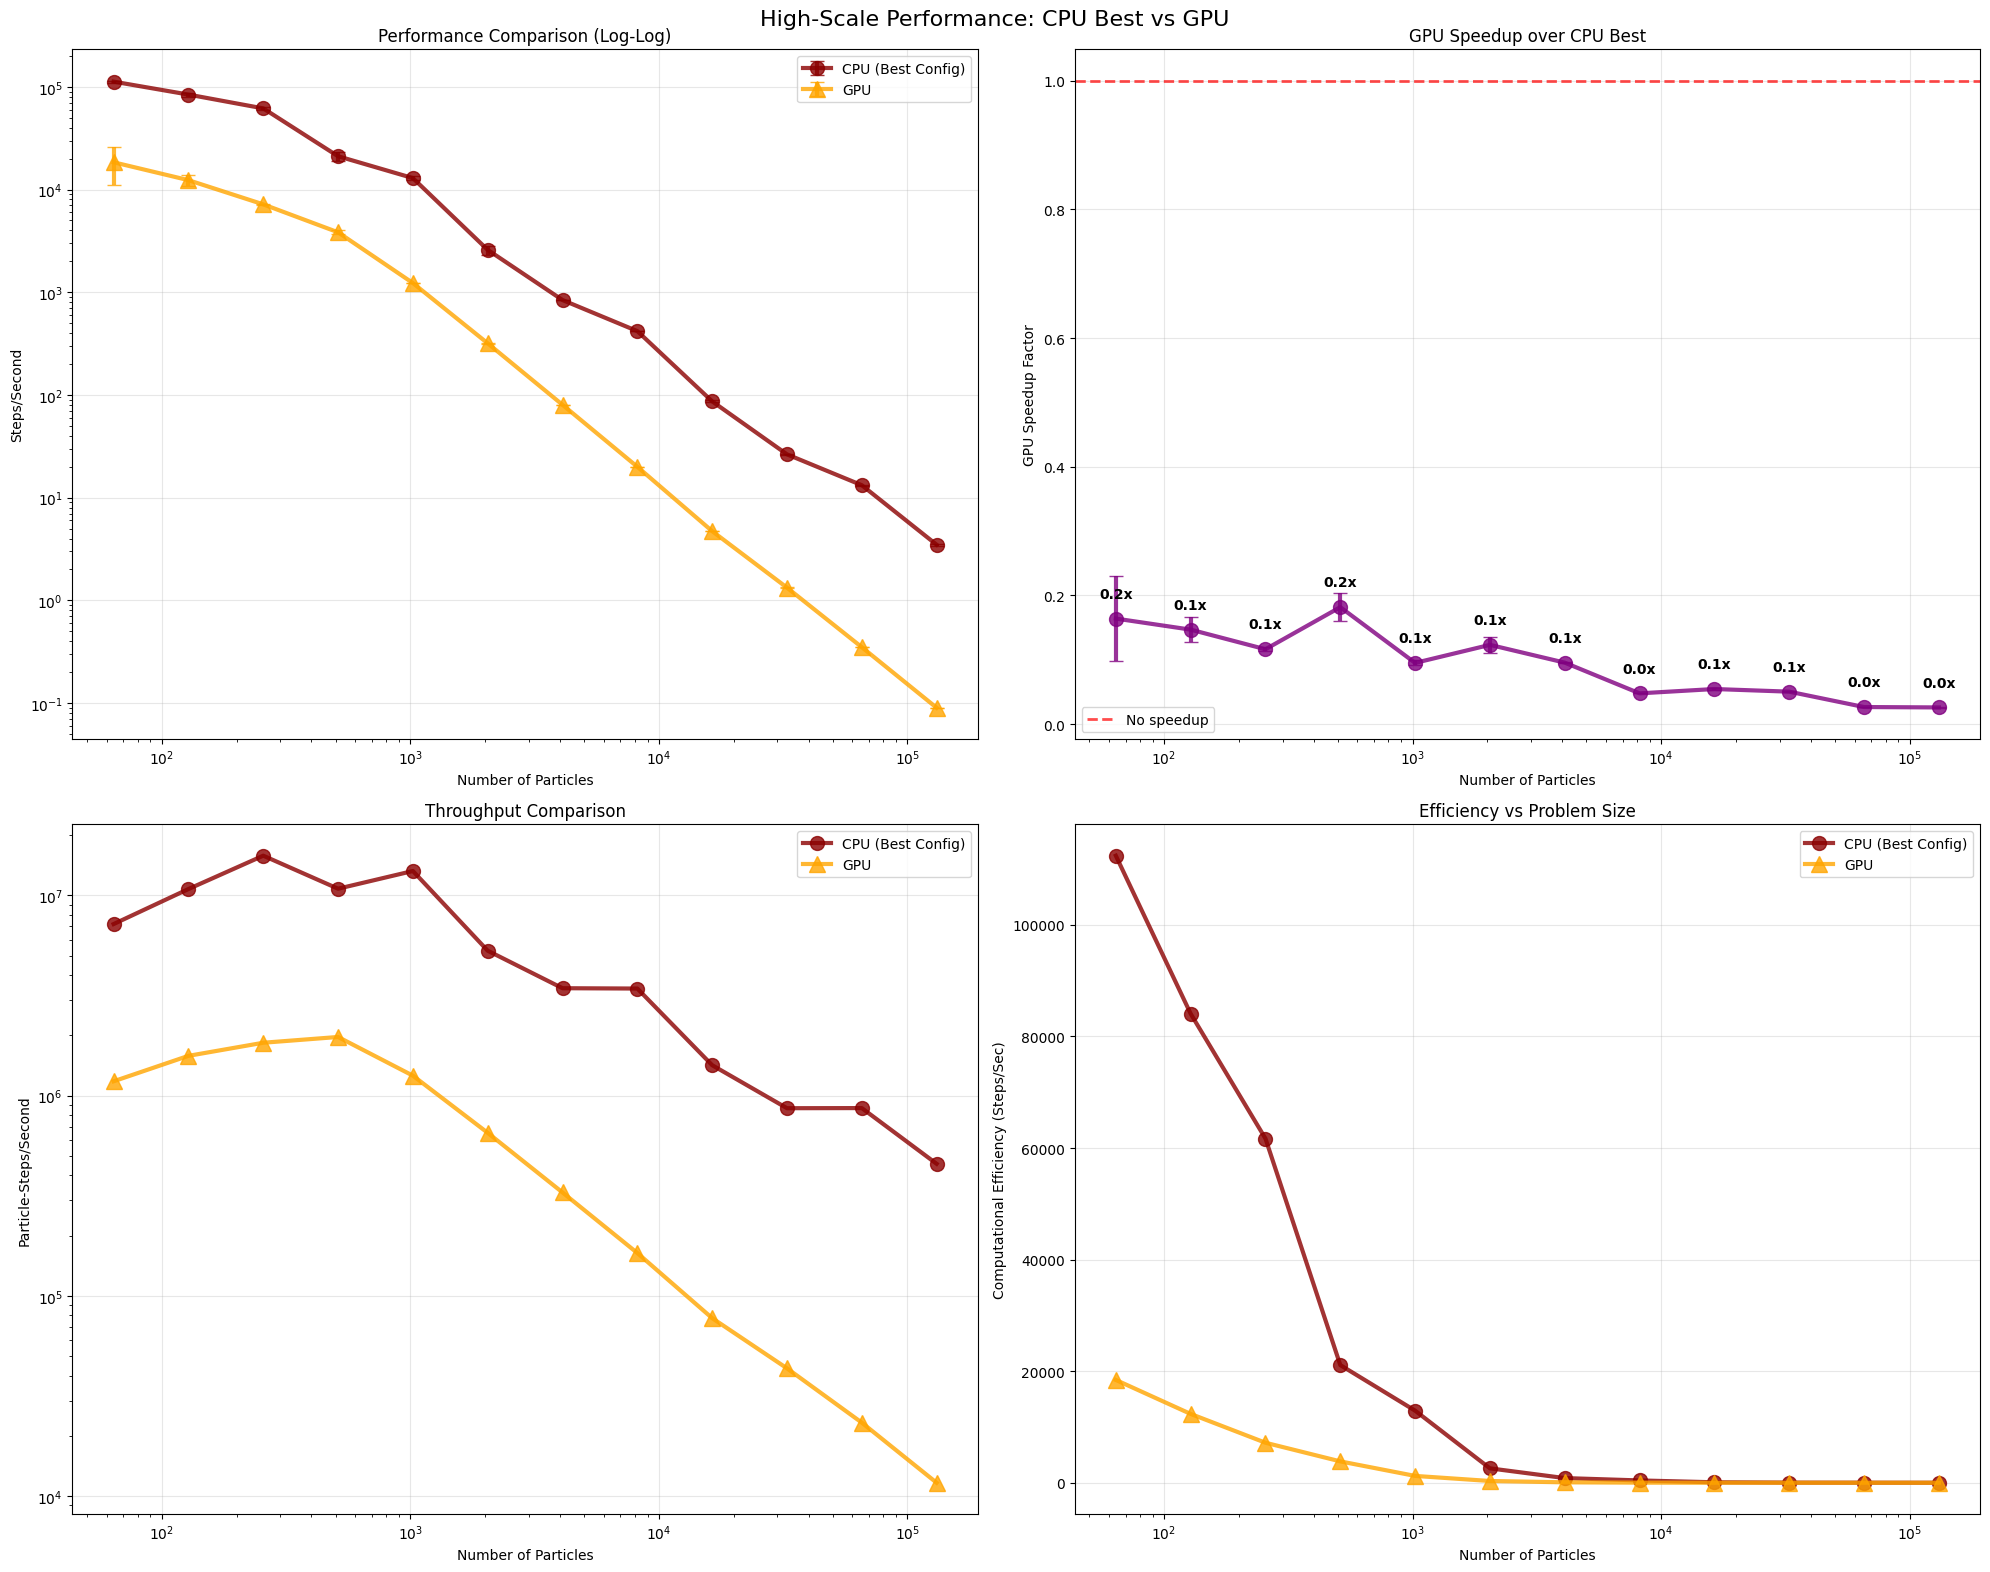

✅ Grafici high-scale completati


In [3]:
# 1. CONFRONTO PRINCIPALE: CPU Best vs GPU per High-Scale
if data_available and len(common_particles) > 0:
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('High-Scale Performance: CPU Best vs GPU', fontsize=16)
    
    print("=== HIGH-SCALE PERFORMANCE CONFRONTO ===")
    
    # Plot 1: Steps/Second comparison (log-log)
    ax1 = axes[0, 0]
    
    # CPU Best
    cpu_common = cpu_best[cpu_best['NumParticles'].isin(common_particles)]
    gpu_common = gpu_data[gpu_data['NumParticles'].isin(common_particles)]
    
    if not cpu_common.empty:
        ax1.errorbar(cpu_common['NumParticles'], cpu_common['MeanStepsPerSecond'],
                    yerr=cpu_common['StdStepsPerSecond'], fmt='o-', 
                    label='CPU (Best Config)', color='darkred', linewidth=3, 
                    markersize=10, capsize=5, alpha=0.8)
    
    if not gpu_common.empty:
        ax1.errorbar(gpu_common['NumParticles'], gpu_common['MeanStepsPerSecond'],
                    yerr=gpu_common['StdStepsPerSecond'], fmt='^-', 
                    label='GPU', color='orange', linewidth=3, 
                    markersize=12, capsize=5, alpha=0.8)
    
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('Number of Particles')
    ax1.set_ylabel('Steps/Second')
    ax1.set_title('Performance Comparison (Log-Log)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: GPU Speedup vs CPU Best
    ax2 = axes[0, 1]
    
    speedups = []
    speedup_errors = []
    particles_list = []
    
    for particles in common_particles:
        cpu_data_point = cpu_common[cpu_common['NumParticles'] == particles]
        gpu_data_point = gpu_common[gpu_common['NumParticles'] == particles]
        
        if not cpu_data_point.empty and not gpu_data_point.empty:
            cpu_perf = cpu_data_point['MeanStepsPerSecond'].iloc[0]
            gpu_perf = gpu_data_point['MeanStepsPerSecond'].iloc[0]
            
            if cpu_perf > 0:
                speedup = gpu_perf / cpu_perf
                speedups.append(speedup)
                particles_list.append(particles)
                
                # Error propagation
                cpu_std = cpu_data_point['StdStepsPerSecond'].iloc[0]
                gpu_std = gpu_data_point['StdStepsPerSecond'].iloc[0]
                speedup_error = speedup * np.sqrt((cpu_std/cpu_perf)**2 + (gpu_std/gpu_perf)**2)
                speedup_errors.append(speedup_error)
                
                print(f"{particles:>6,} particles: GPU {speedup:.2f}±{speedup_error:.2f}x faster than CPU best")
    
    if speedups:
        ax2.errorbar(particles_list, speedups, yerr=speedup_errors, fmt='o-',
                    linewidth=3, markersize=10, capsize=5, color='purple', alpha=0.8)
        
        # Aggiungi valori sui punti
        for x, y in zip(particles_list, speedups):
            ax2.annotate(f'{y:.1f}x', (x, y), textcoords="offset points", 
                        xytext=(0,15), ha='center', fontsize=10, fontweight='bold')
    
    ax2.axhline(y=1, color='red', linestyle='--', alpha=0.7, linewidth=2, label='No speedup')
    ax2.set_xscale('log')
    ax2.set_xlabel('Number of Particles')
    ax2.set_ylabel('GPU Speedup Factor')
    ax2.set_title('GPU Speedup over CPU Best')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Particle-Steps per Second (Throughput)
    ax3 = axes[1, 0]
    
    if not cpu_common.empty:
        throughput_cpu = cpu_common['MeanParticleStepsPerSecond']
        ax3.loglog(cpu_common['NumParticles'], throughput_cpu, 'o-',
                  label='CPU (Best Config)', color='darkred', linewidth=3, markersize=10, alpha=0.8)
    
    if not gpu_common.empty:
        throughput_gpu = gpu_common['MeanParticleStepsPerSecond']
        ax3.loglog(gpu_common['NumParticles'], throughput_gpu, '^-',
                  label='GPU', color='orange', linewidth=3, markersize=12, alpha=0.8)
    
    ax3.set_xlabel('Number of Particles')
    ax3.set_ylabel('Particle-Steps/Second')
    ax3.set_title('Throughput Comparison')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Computational Efficiency (Steps/sec normalized)
    ax4 = axes[1, 1]
    
    # Efficiency = steps per second (higher is better regardless of N)
    if not cpu_common.empty:
        ax4.semilogx(cpu_common['NumParticles'], cpu_common['MeanStepsPerSecond'], 'o-',
                    label='CPU (Best Config)', color='darkred', linewidth=3, markersize=10, alpha=0.8)
    
    if not gpu_common.empty:
        ax4.semilogx(gpu_common['NumParticles'], gpu_common['MeanStepsPerSecond'], '^-',
                    label='GPU', color='orange', linewidth=3, markersize=12, alpha=0.8)
    
    ax4.set_xlabel('Number of Particles')
    ax4.set_ylabel('Computational Efficiency (Steps/Sec)')
    ax4.set_title('Efficiency vs Problem Size')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Grafici high-scale completati")


=== SCALING LAWS ANALYSIS ===
CPU Best Scaling: Performance ∝ N^-1.444 ± 0.061
CPU R² = 0.982, p-value = 4.33e-10
GPU Scaling: Performance ∝ N^-1.696 ± 0.075
GPU R² = 0.981, p-value = 6.19e-10
Speedup Scaling: Speedup ∝ N^-0.252
Speedup R² = 0.861


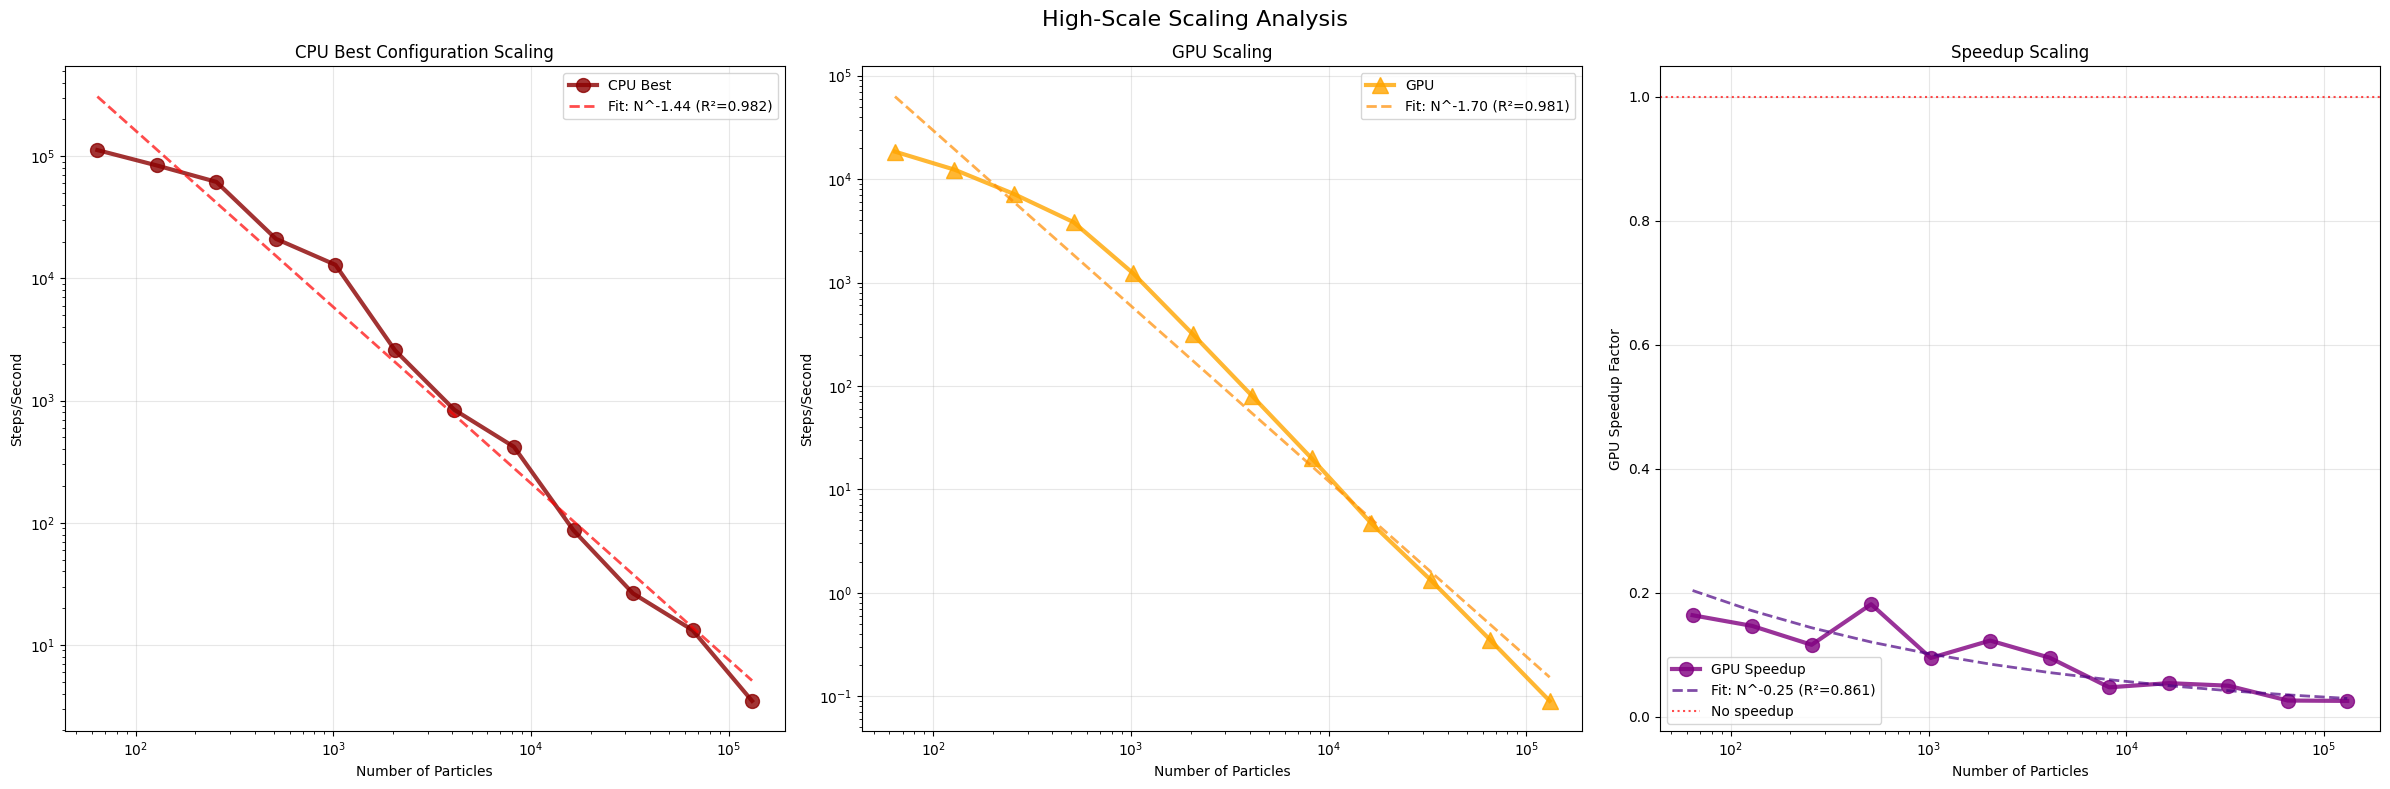

In [4]:
# 2. ANALISI SCALING LAWS per High-Scale
if data_available:
    
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    fig.suptitle('High-Scale Scaling Analysis', fontsize=16)
    
    print("\n=== SCALING LAWS ANALYSIS ===")
    
    # Plot 1: CPU Best Configuration Scaling
    ax1 = axes[0]
    
    if len(cpu_best) >= 3:
        log_n = np.log10(cpu_best['NumParticles'])
        log_perf = np.log10(cpu_best['MeanStepsPerSecond'])
        
        # Fit lineare in log-log
        slope, intercept, r_value, p_value, std_err = stats.linregress(log_n, log_perf)
        
        # Plot dati
        ax1.loglog(cpu_best['NumParticles'], cpu_best['MeanStepsPerSecond'], 'o-',
                  color='darkred', linewidth=3, markersize=10, alpha=0.8, label='CPU Best')
        
        # Plot fit
        fit_line = 10**(intercept + slope * log_n)
        ax1.loglog(cpu_best['NumParticles'], fit_line, '--',
                  color='red', linewidth=2, alpha=0.7, 
                  label=f'Fit: N^{slope:.2f} (R²={r_value**2:.3f})')
        
        print(f"CPU Best Scaling: Performance ∝ N^{slope:.3f} ± {std_err:.3f}")
        print(f"CPU R² = {r_value**2:.3f}, p-value = {p_value:.2e}")
    
    ax1.set_xlabel('Number of Particles')
    ax1.set_ylabel('Steps/Second')
    ax1.set_title('CPU Best Configuration Scaling')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: GPU Scaling
    ax2 = axes[1]
    
    if len(gpu_data) >= 3:
        log_n_gpu = np.log10(gpu_data['NumParticles'])
        log_perf_gpu = np.log10(gpu_data['MeanStepsPerSecond'])
        
        slope_gpu, intercept_gpu, r_value_gpu, p_value_gpu, std_err_gpu = stats.linregress(log_n_gpu, log_perf_gpu)
        
        ax2.loglog(gpu_data['NumParticles'], gpu_data['MeanStepsPerSecond'], '^-',
                  color='orange', linewidth=3, markersize=12, alpha=0.8, label='GPU')
        
        fit_line_gpu = 10**(intercept_gpu + slope_gpu * log_n_gpu)
        ax2.loglog(gpu_data['NumParticles'], fit_line_gpu, '--',
                  color='darkorange', linewidth=2, alpha=0.7,
                  label=f'Fit: N^{slope_gpu:.2f} (R²={r_value_gpu**2:.3f})')
        
        print(f"GPU Scaling: Performance ∝ N^{slope_gpu:.3f} ± {std_err_gpu:.3f}")
        print(f"GPU R² = {r_value_gpu**2:.3f}, p-value = {p_value_gpu:.2e}")
    
    ax2.set_xlabel('Number of Particles')
    ax2.set_ylabel('Steps/Second')
    ax2.set_title('GPU Scaling')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Speedup Scaling (se abbiamo dati comuni)
    ax3 = axes[2]
    
    if len(speedups) >= 3 and len(particles_list) >= 3:
        log_n_speedup = np.log10(particles_list)
        log_speedup = np.log10(speedups)
        
        slope_speedup, intercept_speedup, r_value_speedup, _, _ = stats.linregress(log_n_speedup, log_speedup)
        
        ax3.semilogx(particles_list, speedups, 'o-',
                    color='purple', linewidth=3, markersize=10, alpha=0.8, label='GPU Speedup')
        
        fit_speedup = 10**(intercept_speedup + slope_speedup * log_n_speedup)
        ax3.semilogx(particles_list, fit_speedup, '--',
                    color='indigo', linewidth=2, alpha=0.7,
                    label=f'Fit: N^{slope_speedup:.2f} (R²={r_value_speedup**2:.3f})')
        
        print(f"Speedup Scaling: Speedup ∝ N^{slope_speedup:.3f}")
        print(f"Speedup R² = {r_value_speedup**2:.3f}")
    
    ax3.axhline(y=1, color='red', linestyle=':', alpha=0.7, label='No speedup')
    ax3.set_xlabel('Number of Particles')
    ax3.set_ylabel('GPU Speedup Factor')
    ax3.set_title('Speedup Scaling')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [5]:
# 3. TABELLA RIASSUNTIVA HIGH-SCALE
if data_available:
    
    print("\n=== HIGH-SCALE PERFORMANCE SUMMARY ===")
    
    summary_table = []
    
    # Analizza performance per range di particelle
    particle_ranges = [
        (1, 1000, "Small (1-1K)"),
        (1001, 10000, "Medium (1K-10K)"),
        (10001, 50000, "Large (10K-50K)"),
        (50001, 100000, "Very Large (50K-100K)")
    ]
    
    for min_p, max_p, range_name in particle_ranges:
        cpu_range = cpu_best[(cpu_best['NumParticles'] >= min_p) & (cpu_best['NumParticles'] <= max_p)]
        gpu_range = gpu_data[(gpu_data['NumParticles'] >= min_p) & (gpu_data['NumParticles'] <= max_p)]
        
        if not cpu_range.empty or not gpu_range.empty:
            row = {'Range': range_name}
            
            if not cpu_range.empty:
                best_cpu = cpu_range.loc[cpu_range['MeanStepsPerSecond'].idxmax()]
                row.update({
                    'CPU_Best_N': f"{best_cpu['NumParticles']:,}",
                    'CPU_Performance': f"{best_cpu['MeanStepsPerSecond']:.1e}",
                    'CPU_Method': f"{best_cpu['ForceMethod']}+{best_cpu['IntegrationMethod']}",
                    'CPU_Threads': int(best_cpu['NumThreads'])
                })
            
            if not gpu_range.empty:
                best_gpu = gpu_range.loc[gpu_range['MeanStepsPerSecond'].idxmax()]
                row.update({
                    'GPU_Best_N': f"{best_gpu['NumParticles']:,}",
                    'GPU_Performance': f"{best_gpu['MeanStepsPerSecond']:.1e}",
                })
                
                # Calcola speedup se possibile
                if not cpu_range.empty:
                    # Trova CPU performance per stesso N se disponibile
                    same_n_cpu = cpu_best[cpu_best['NumParticles'] == best_gpu['NumParticles']]
                    if not same_n_cpu.empty:
                        speedup = best_gpu['MeanStepsPerSecond'] / same_n_cpu['MeanStepsPerSecond'].iloc[0]
                        row['Speedup'] = f"{speedup:.2f}x"
            
            summary_table.append(row)
    
    if summary_table:
        summary_df = pd.DataFrame(summary_table)
        print(summary_df.to_string(index=False))
    
    # Performance peaks
    print(f"\n=== PERFORMANCE PEAKS ===")
    
    if not cpu_best.empty:
        peak_cpu = cpu_best.loc[cpu_best['MeanStepsPerSecond'].idxmax()]
        print(f"🏆 CPU Peak: {peak_cpu['MeanStepsPerSecond']:.1e} steps/sec")
        print(f"   └─ {peak_cpu['NumParticles']:,} particles, {peak_cpu['ForceMethod']}+{peak_cpu['IntegrationMethod']}, {peak_cpu['NumThreads']} threads")
    
    if not gpu_data.empty:
        peak_gpu = gpu_data.loc[gpu_data['MeanStepsPerSecond'].idxmax()]
        print(f"🚀 GPU Peak: {peak_gpu['MeanStepsPerSecond']:.1e} steps/sec")
        print(f"   └─ {peak_gpu['NumParticles']:,} particles")
        
        # Confronto diretto se disponibile
        same_n_cpu = cpu_best[cpu_best['NumParticles'] == peak_gpu['NumParticles']]
        if not same_n_cpu.empty:
            direct_speedup = peak_gpu['MeanStepsPerSecond'] / same_n_cpu['MeanStepsPerSecond'].iloc[0]
            print(f"   └─ {direct_speedup:.2f}x faster than CPU at same N")
    
    # Crossover analysis
    print(f"\n=== CROSSOVER ANALYSIS ===")
    
    if len(common_particles) > 0 and len(speedups) > 0:
        # Trova dove GPU diventa più veloce
        gpu_faster = [s > 1 for s in speedups]
        if any(gpu_faster):
            first_gpu_win = particles_list[gpu_faster.index(True)]
            print(f"🎯 GPU diventa più veloce a {first_gpu_win:,} particelle")
        else:
            print("🤔 CPU sempre più veloce nel range testato")
        
        # Trova il massimo vantaggio GPU
        max_speedup_idx = speedups.index(max(speedups))
        max_speedup_n = particles_list[max_speedup_idx]
        max_speedup_val = speedups[max_speedup_idx]
        print(f"⚡ Massimo vantaggio GPU: {max_speedup_val:.2f}x a {max_speedup_n:,} particelle")
    
    print("\n✅ Analisi high-scale completata!")


=== HIGH-SCALE PERFORMANCE SUMMARY ===
                Range CPU_Best_N CPU_Performance                 CPU_Method  CPU_Threads GPU_Best_N GPU_Performance Speedup
         Small (1-1K)         64         1.1e+05 BARNES_HUT+VELOCITY_VERLET            2         64         1.8e+04   0.16x
      Medium (1K-10K)      1,024         1.3e+04 BARNES_HUT+VELOCITY_VERLET            4      1,024         1.2e+03   0.10x
      Large (10K-50K)     16,384         8.7e+01 BARNES_HUT+VELOCITY_VERLET            6     16,384         4.7e+00   0.05x
Very Large (50K-100K)     65,536         1.3e+01 BARNES_HUT+VELOCITY_VERLET            4     65,536         3.5e-01   0.03x

=== PERFORMANCE PEAKS ===
🏆 CPU Peak: 1.1e+05 steps/sec
   └─ 64 particles, BARNES_HUT+VELOCITY_VERLET, 2 threads
🚀 GPU Peak: 1.8e+04 steps/sec
   └─ 64 particles
   └─ 0.16x faster than CPU at same N

=== CROSSOVER ANALYSIS ===
🤔 CPU sempre più veloce nel range testato
⚡ Massimo vantaggio GPU: 0.18x a 512 particelle

✅ Analisi high-scal


=== BARNES-HUT THREAD SCALING ANALYSIS ===
Verifica che Barnes-Hut funzioni solo in single-thread

Barnes-Hut Threading Degradation:


TypeError: Axes.boxplot() got an unexpected keyword argument 'alpha'

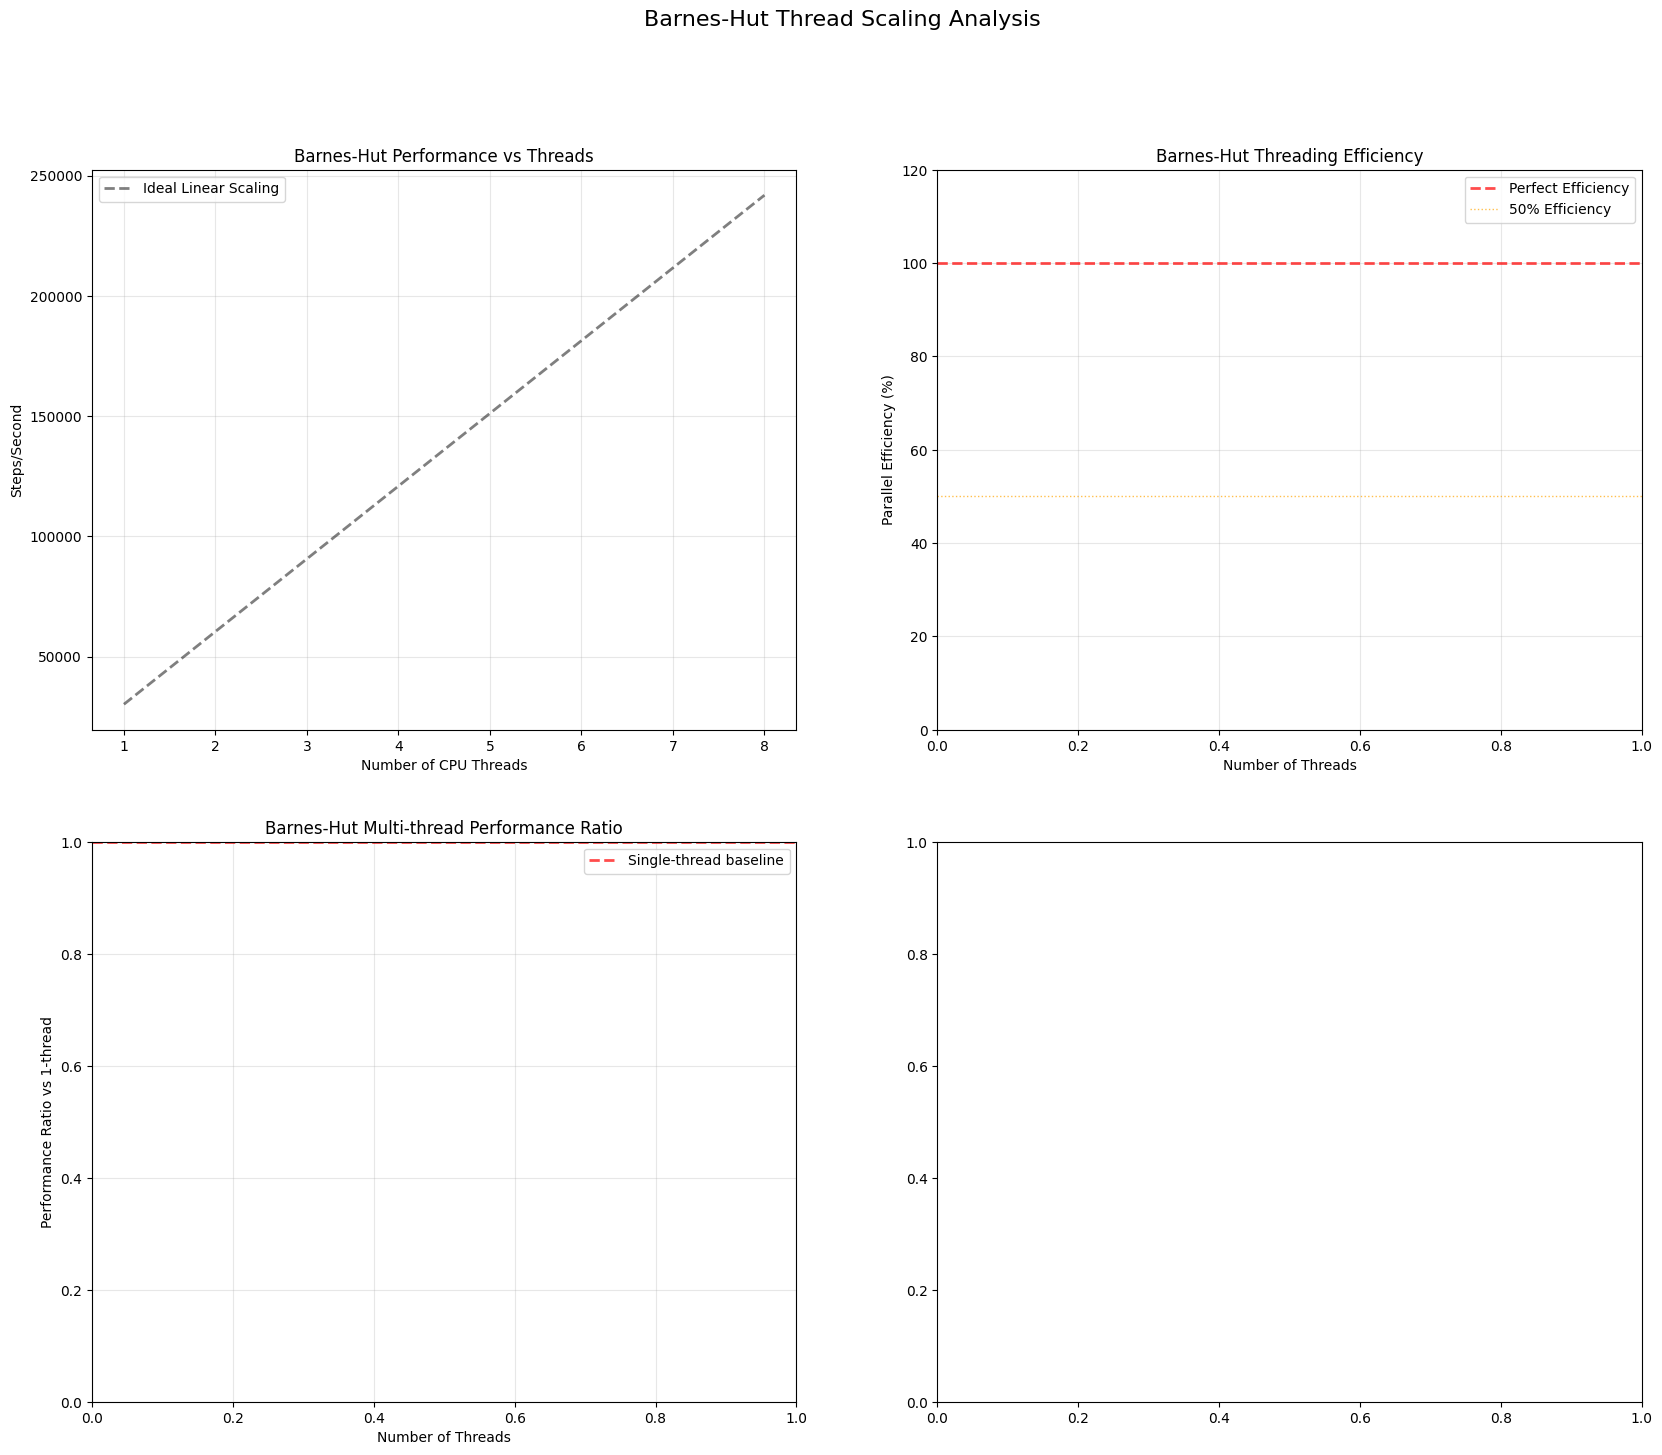

In [6]:
# 4. BARNES-HUT THREAD SCALING ANALYSIS
if data_available:
    
    print("\n=== BARNES-HUT THREAD SCALING ANALYSIS ===")
    print("Verifica che Barnes-Hut funzioni solo in single-thread")
    
    # Estrai dati Barnes-Hut da tutti i dataset CPU
    bh_data = df_cpu_all[df_cpu_all['ForceMethod'] == 'BARNES_HUT'].copy()
    
    if not bh_data.empty:
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        fig.suptitle('Barnes-Hut Thread Scaling Analysis', fontsize=16)
        
        # Plot 1: Performance vs Threads per diversi numeri di particelle
        ax1 = axes[0, 0]
        
        representative_particles = [1000, 5000, 10000, 25000]
        colors = plt.cm.Set1(np.linspace(0, 1, len(representative_particles)))
        
        for particles, color in zip(representative_particles, colors):
            particle_data = bh_data[bh_data['NumParticles'] == particles]
            
            if not particle_data.empty:
                particle_data_sorted = particle_data.sort_values('NumThreads')
                
                ax1.errorbar(particle_data_sorted['NumThreads'], 
                            particle_data_sorted['MeanStepsPerSecond'],
                            yerr=particle_data_sorted['StdStepsPerSecond'],
                            fmt='o-', label=f'{particles:,} particles', color=color,
                            linewidth=2.5, markersize=8, capsize=4, alpha=0.85)
                
                # Calcola speedup vs single thread
                baseline = particle_data_sorted[particle_data_sorted['NumThreads'] == 1]['MeanStepsPerSecond']
                if not baseline.empty:
                    baseline_perf = baseline.iloc[0]
                    max_perf = particle_data_sorted['MeanStepsPerSecond'].max()
                    max_threads = particle_data_sorted.loc[particle_data_sorted['MeanStepsPerSecond'].idxmax(), 'NumThreads']
                    thread_speedup = max_perf / baseline_perf
                    print(f"Barnes-Hut {particles:,} particles: max {thread_speedup:.2f}x speedup ({max_threads} threads)")
        
        # Aggiungi linea ideale per confronto
        thread_range = sorted(bh_data['NumThreads'].unique())
        if len(thread_range) > 1:
            baseline_avg = bh_data[bh_data['NumThreads'] == 1]['MeanStepsPerSecond'].mean()
            if baseline_avg > 0:
                ideal_scaling = [baseline_avg * t for t in thread_range]
                ax1.plot(thread_range, ideal_scaling, 'k--', alpha=0.5, 
                        linewidth=2, label='Ideal Linear Scaling')
        
        ax1.set_xlabel('Number of CPU Threads')
        ax1.set_ylabel('Steps/Second')
        ax1.set_title('Barnes-Hut Performance vs Threads')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Parallel Efficiency
        ax2 = axes[0, 1]
        
        for particles, color in zip(representative_particles[:3], colors):  # Limita per leggibilità
            particle_data = bh_data[bh_data['NumParticles'] == particles]
            
            if len(particle_data) > 1:
                particle_data_sorted = particle_data.sort_values('NumThreads')
                baseline = particle_data_sorted[particle_data_sorted['NumThreads'] == 1]['MeanStepsPerSecond']
                
                if not baseline.empty:
                    baseline_perf = baseline.iloc[0]
                    
                    efficiencies = []
                    thread_counts = []
                    
                    for _, row in particle_data_sorted.iterrows():
                        threads = row['NumThreads']
                        if threads > 0:
                            actual_speedup = row['MeanStepsPerSecond'] / baseline_perf
                            efficiency = (actual_speedup / threads) * 100
                            
                            if 0 <= efficiency <= 200:  # Filtro valori sensati
                                efficiencies.append(efficiency)
                                thread_counts.append(threads)
                    
                    if len(efficiencies) >= 2:
                        ax2.plot(thread_counts, efficiencies, 'o-', 
                                label=f'{particles:,} particles', color=color, 
                                linewidth=2.5, markersize=8, alpha=0.85)
        
        ax2.axhline(y=100, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Perfect Efficiency')
        ax2.axhline(y=50, color='orange', linestyle=':', alpha=0.7, linewidth=1, label='50% Efficiency')
        ax2.set_xlabel('Number of Threads')
        ax2.set_ylabel('Parallel Efficiency (%)')
        ax2.set_title('Barnes-Hut Threading Efficiency')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0, 120)
        
        # Plot 3: Degradazione performance con threads
        ax3 = axes[1, 0]
        
        print(f"\nBarnes-Hut Threading Degradation:")
        for particles in [2500, 5000, 10000, 25000]:
            particle_data = bh_data[bh_data['NumParticles'] == particles]
            
            if len(particle_data) > 1:
                particle_data_sorted = particle_data.sort_values('NumThreads')
                baseline = particle_data_sorted[particle_data_sorted['NumThreads'] == 1]['MeanStepsPerSecond']
                
                if not baseline.empty:
                    baseline_perf = baseline.iloc[0]
                    
                    # Calcola ratio rispetto al single-thread
                    ratios = particle_data_sorted['MeanStepsPerSecond'] / baseline_perf
                    
                    ax3.plot(particle_data_sorted['NumThreads'], ratios, 
                            'o-', label=f'{particles:,} particles', 
                            linewidth=2.5, markersize=8, alpha=0.85)
                    
                    # Trova il peggioramento massimo
                    min_ratio = ratios.min()
                    max_ratio = ratios.max()
                    degradation = (1 - min_ratio) * 100
                    improvement = (max_ratio - 1) * 100
                    print(f"  {particles:,} particles: degradazione max {degradation:.1f}%, miglioramento max {improvement:.1f}%")
        
        ax3.axhline(y=1, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Single-thread baseline')
        ax3.set_xlabel('Number of Threads')
        ax3.set_ylabel('Performance Ratio vs 1-thread')
        ax3.set_title('Barnes-Hut Multi-thread Performance Ratio')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Distribuzione performance per thread count
        ax4 = axes[1, 1]
        
        # Boxplot delle performance per numero di thread
        thread_counts = sorted(bh_data['NumThreads'].unique())
        performance_by_threads = []
        
        for threads in thread_counts:
            thread_perf = bh_data[bh_data['NumThreads'] == threads]['MeanStepsPerSecond']
            performance_by_threads.append(thread_perf)
        
        if performance_by_threads and all(len(p) > 0 for p in performance_by_threads):
            ax4.boxplot(performance_by_threads, labels=[f'{t}T' for t in thread_counts],
                       patch_artist=True, alpha=0.7)
            ax4.set_xlabel('Number of Threads')
            ax4.set_ylabel('Steps/Second Distribution')
            ax4.set_title('Barnes-Hut Performance Distribution by Thread Count')
            ax4.grid(True, alpha=0.3)
            ax4.set_yscale('log')
        
        plt.tight_layout()
        plt.show()
        
        # Analisi statistiche Barnes-Hut
        print(f"\n=== BARNES-HUT THREADING CONCLUSIONS ===")
        
        # Calcola statistiche aggregate
        single_thread_data = bh_data[bh_data['NumThreads'] == 1]
        multi_thread_data = bh_data[bh_data['NumThreads'] > 1]
        
        if not single_thread_data.empty and not multi_thread_data.empty:
            avg_single = single_thread_data['MeanStepsPerSecond'].mean()
            avg_multi = multi_thread_data['MeanStepsPerSecond'].mean()
            
            print(f"Media performance single-thread: {avg_single:.0f} steps/sec")
            print(f"Media performance multi-thread: {avg_multi:.0f} steps/sec")
            print(f"Ratio multi/single: {avg_multi/avg_single:.3f}")
            
            if avg_multi < avg_single:
                print("🔴 CONFERMA: Barnes-Hut degrada con multi-threading")
                degradation = (1 - avg_multi/avg_single) * 100
                print(f"   Degradazione media: {degradation:.1f}%")
            else:
                print("🟡 Barnes-Hut mostra leggero miglioramento con threading")
                improvement = (avg_multi/avg_single - 1) * 100
                print(f"   Miglioramento medio: {improvement:.1f}%")
        
        # Raccomandazione finale
        best_single_perf = single_thread_data['MeanStepsPerSecond'].max() if not single_thread_data.empty else 0
        best_multi_perf = multi_thread_data['MeanStepsPerSecond'].max() if not multi_thread_data.empty else 0
        
        print(f"\n🎯 RACCOMANDAZIONE BARNES-HUT:")
        if best_single_perf >= best_multi_perf:
            print("   Usa Barnes-Hut con 1 THREAD per performance ottimali")
            print("   Il tree-building non si parallelizza efficacemente")
        else:
            print("   Barnes-Hut può beneficiare di multi-threading in alcuni casi")
            print("   Testa configurazione ottimale per il tuo caso d'uso")
    
    else:
        print("❌ Nessun dato Barnes-Hut trovato per l'analisi threading")

print("\n✅ Analisi completa high-scale + Barnes-Hut threading completata!")